In [55]:
from deep_gamma import DATA_PATH
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import namedtuple
from rdkit import Chem
import seaborn as sns

In [13]:
# aspen_base_path = DATA_PATH / "07_model_output" / "aspen_base_fingerprints"
# aspen_base_dfs = {
#     path.stem: pd.read_csv(path)
#     for path in aspen_base_path.glob("*.csv")
# }
aspen_pretrained_path = DATA_PATH / "07_model_output" / "aspen_pretrained_fingerprints"
aspen_pretrained_dfs = {
    path.stem: pd.read_csv(path)
    for path in aspen_pretrained_path.glob("*.csv")
}

In [8]:
aspen_base = pd.read_csv(DATA_PATH / "05_model_input" / "aspen" / "train.csv")

In [29]:
def merge(mol, marked, aset):
    bset = set()
    for idx in aset:
        atom = mol.GetAtomWithIdx(idx)
        for nbr in atom.GetNeighbors():
            jdx = nbr.GetIdx()
            if jdx in marked:
                marked.remove(jdx)
                bset.add(jdx)
    if not bset:
        return
    merge(mol, marked, bset)
    aset.update(bset)

# atoms connected by non-aromatic double or triple bond to any heteroatom
# c=O should not match (see fig1, box 15).  I think using A instead of * should sort that out?
PATT_DOUBLE_TRIPLE = Chem.MolFromSmarts('A=,#[!#6]')
# atoms in non aromatic carbon-carbon double or triple bonds
PATT_CC_DOUBLE_TRIPLE = Chem.MolFromSmarts('C=,#C')
# acetal carbons, i.e. sp3 carbons connected to tow or more oxygens, nitrogens or sulfurs; these O, N or S atoms must have only single bonds
PATT_ACETAL = Chem.MolFromSmarts('[CX4](-[O,N,S])-[O,N,S]')
# all atoms in oxirane, aziridine and thiirane rings
PATT_OXIRANE_ETC = Chem.MolFromSmarts('[O,N,S]1CC1')

PATT_TUPLE = (PATT_DOUBLE_TRIPLE, PATT_CC_DOUBLE_TRIPLE, PATT_ACETAL, PATT_OXIRANE_ETC)

def identify_functional_groups(mol):
    marked = set()
    #mark all heteroatoms in a molecule, including halogens
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() not in (6,1): # would we ever have hydrogen?
            marked.add(atom.GetIdx())

    #mark the four specific types of carbon atom
    for patt in PATT_TUPLE:
        for path in mol.GetSubstructMatches(patt):
            for atomindex in path:
                marked.add(atomindex)

    #merge all connected marked atoms to a single FG
    groups = []
    while marked:
        grp = set([marked.pop()])
        merge(mol, marked, grp)
        groups.append(grp)

    #extract also connected unmarked carbon atoms
    ifg = namedtuple('IFG', ['atomIds', 'atoms', 'type'])
    ifgs = []
    for g in groups:
        uca = set()
        for atomidx in g:
            for n in mol.GetAtomWithIdx(atomidx).GetNeighbors():
                if n.GetAtomicNum() == 6:
                    uca.add(n.GetIdx())
        ifgs.append(ifg(atomIds=tuple(list(g)), atoms=Chem.MolFragmentToSmiles(mol, g, canonical=True), type=Chem.MolFragmentToSmiles(mol, g.union(uca),canonical=True)))
    return ifgs

def main():
    for ix, smiles in enumerate([
        'Cc1nc(NS(=O)(=O)c2ccc(N)cc2)nc(C)c1', # fig1, 1
        'NC(=N)c1ccc(C=Cc2ccc(cc2O)C(=N)N)cc1', # 2
        'CC(=O)Nc1nnc(s1)S(=O)(=O)N', # 3
        'NS(=O)(=O)c1cc2c(NCNS2(=O)=O)cc1Cl', # 4
        'CNC1=Nc2ccc(Cl)cc2C(=N(=O)C1)c3ccccc3', # 5
        'Cc1onc(c1C(=O)NC2C3SC(C)(C)C(N3C2=O)C(=O)O)c4ccccc4', # 6
        'Clc1ccccc1C2=NCC(=O)Nc3ccc(cc23)N(=O)=O', # 7
        'COc1cc(cc(C(=O)NCC2CCCN2CC=C)c1OC)S(=O)(=O)N', # 8
        'Cc1ccc(Cl)c(Nc2ccccc2C(=O)O)c1Cl', # 9
        'Clc1ccc2Oc3ccccc3N=C(N4CCNCC4)c2c1', # 10 - there is a discrepancy with the paper here!  I wonder if Peter has the ring as aromatic?
        'FC(F)(F)CN1C(=O)CN=C(c2ccccc2)c3cc(Cl)ccc13', # 11
        'OCC1OC(CC1O)n2cnc3C(O)CNC=Nc32', # 12
        'CCNC1CC(C)S(=O)(=O)c2sc(cc12)S(=O)(=O)N', # 13
        'CC(O)C1C2C(C)C(=C(N2C1=O)C(=O)O)SC3CNC(C3)C(=O)N(C)C', # 14
        'CC1CN(CC(C)N1)c2c(F)c(N)c3c(=O)c(cn(C4CC4)c3c2F)C(=O)O', # 15
        'CC(=CCC1C(=O)N(N(C1=O)c2ccccc2)c3ccccc3)C', # 16
        'Clc1ccc2N=C3NC(=O)CN3Cc2c1Cl', # 17
        'CC(=O)NC1C(NC(=N)N)C=C(OC1C(O)C(O)CO)C(=O)O', # 18
        'CC(O)C(O)C1CNc2nc(N)nc(O)c2N1', # 19
        'NC1CCCCN(C1)c2c(Cl)cc3c(=O)c(cn(C4CC4)c3c2Cl)C(=O)O', # 20
    ]):
        m = Chem.MolFromSmiles(smiles)
        fgs = identify_functional_groups(m)
        return fgs
        # print('%2d: %d fgs'%(ix+1, len(fgs)), fgs)
    

## Base model

### PCA

In [9]:
df = aspen_base_dfs["train_preds"].drop_duplicates(
    subset=["smiles_1", "smiles_2"]
).drop(
    ["smiles_1", "smiles_2"], axis=1
)
arr = df.to_numpy()
scaler = StandardScaler()
arr = scaler.fit_transform(arr)
pca = PCA()
X = pca.fit_transform(arr)
pca_df = pd.DataFrame(X[:, :2], columns=["PC1", "PC2"])
pca_df = pd.concat([pca_df, aspen_base], axis=1)

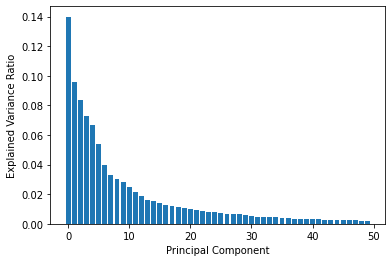

In [10]:
z = pca.explained_variance_ratio_[:50]
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.bar(np.arange(len(z)), z)
plt.savefig(DATA_PATH  / "08_reporting" / "base_fingerprints_pca_explained_varaince.png", dpi=300)

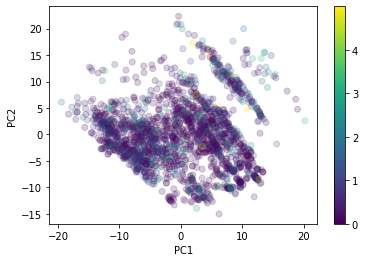

In [11]:
fig, ax = plt.subplots(1)
subset_df = pca_df[pca_df["ln_gamma_1"].abs() < 5]
sc = ax.scatter(
    subset_df["PC1"], 
    subset_df["PC2"], 
    c=subset_df["ln_gamma_1"], 
    alpha=0.2
)
cb = plt.colorbar(sc)
cb.solids.set(alpha=1)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
fig.savefig(DATA_PATH / "08_reporting" / "aspen" / "base_fingerprints_pca.png", dpi=300)

### T-SNE

In [16]:
df = aspen_base_dfs["train_preds"].drop_duplicates(
    subset=["smiles_1", "smiles_2"]
).drop(
    ["smiles_1", "smiles_2"], axis=1
)
arr = df.to_numpy()
scaler = StandardScaler()
arr = scaler.fit_transform(arr)
tsne = TSNE(n_components=2, perplexity=20)
X = tsne.fit_transform(arr)
tsne_df = pd.DataFrame(X[:, :2], columns=["TC1", "TC2"])
tsne_df = pd.concat([tsne_df, aspen_base], axis=1)

/Users/Kobi/Documents/Research/phd_code/deep_gamma/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/Kobi/Documents/Research/phd_code/deep_gamma/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


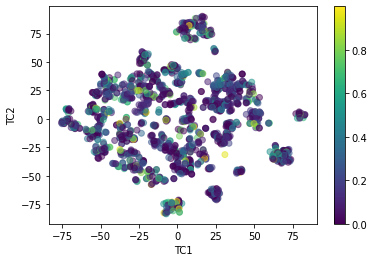

In [17]:
fig, ax = plt.subplots(1)
subset_df = tsne_df[tsne_df["ln_gamma_1"].abs() < 1]
sc = ax.scatter(
    subset_df["TC1"], 
    subset_df["TC2"], 
    c=subset_df["ln_gamma_1"], 
    alpha=0.5
)
cb = plt.colorbar(sc)
cb.solids.set(alpha=1)
ax.set_xlabel("TC1")
ax.set_ylabel("TC2")
fig.savefig(DATA_PATH / "08_reporting" / "aspen" / "base_fingerprints_t_sne.png", dpi=300)

## Pretrained model

### PCA

In [14]:
df = aspen_pretrained_dfs["train_preds"].drop_duplicates(
    subset=["smiles_1", "smiles_2"]
).drop(
    ["smiles_1", "smiles_2"], axis=1
)
arr = df.to_numpy()
scaler = StandardScaler()
arr = scaler.fit_transform(arr)
pca = PCA()
X = pca.fit_transform(arr)
pca_pretrain_df = pd.DataFrame(X[:, :2], columns=["PC1", "PC2"])
pca_pretrain_df = pd.concat([pca_pretrain_df, aspen_base], axis=1)

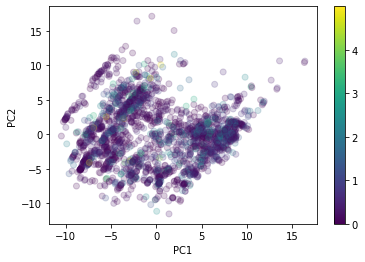

In [15]:
fig, ax = plt.subplots(1)
subset_df = pca_pretrain_df[pca_pretrain_df["ln_gamma_1"].abs() < 5]
sc = ax.scatter(
    subset_df["PC1"], 
    subset_df["PC2"], 
    c=subset_df["ln_gamma_1"], 
    alpha=0.2
)
cb = plt.colorbar(sc)
cb.solids.set(alpha=1)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
fig.savefig(DATA_PATH / "08_reporting" / "aspen" / "pretrained_fingerprints_pca.png", dpi=300)

### T-SNE

In [22]:
df = aspen_pretrained_dfs["train_preds"].drop_duplicates(
    subset=["smiles_1", "smiles_2"]
).drop(
    ["smiles_1", "smiles_2"], axis=1
)
arr = df.to_numpy()
scaler = StandardScaler()
arr = scaler.fit_transform(arr)
tsne = TSNE(n_components=2, perplexity=30)
X = tsne.fit_transform(arr)
tsne_df = pd.DataFrame(X[:, :2], columns=["TC1", "TC2"])
tsne_df = pd.concat([tsne_df, aspen_base], axis=1)

/Users/Kobi/Documents/Research/phd_code/deep_gamma/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/Kobi/Documents/Research/phd_code/deep_gamma/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0, 0.5, 'TC2')

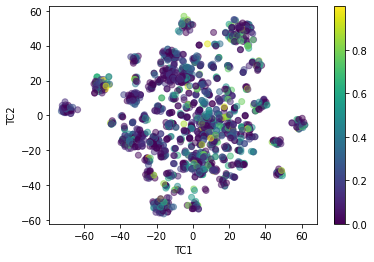

In [23]:
fig, ax = plt.subplots(1)
subset_df = tsne_df[tsne_df["ln_gamma_1"].abs() < 1]
sc = ax.scatter(
    subset_df["TC1"], 
    subset_df["TC2"], 
    c=subset_df["ln_gamma_1"], 
    alpha=0.5
)
cb = plt.colorbar(sc)
cb.solids.set(alpha=1)
ax.set_xlabel("TC1")
ax.set_ylabel("TC2")
fig.savefig(DATA_PATH / "08_reporting" / "aspen" / "pretrained_fingerprints_t_sne.png", dpi=300)

### Functional Group Analysis

In [30]:
fgs = main()

In [33]:
smiles_list = aspen_pretrained_dfs["train_preds"]["smiles_1"].unique()

In [34]:
fgs_dict = {
    smiles: identify_functional_groups(
        Chem.MolFromSmiles(smiles)
    )
    for smiles in smiles_list
}

In [85]:
fgs_dict_unroll = [
    [smiles, fgs[0].type if len(fgs)>0 else ""]
    for smiles, fgs in fgs_dict.items()
]
fgs_df = pd.DataFrame(fgs_dict_unroll, columns=["smiles", "fg"])

In [86]:
tnse_df_fg = tsne_df.merge(fgs_df, left_on="smiles_1", right_on="smiles", how="left")

/var/folders/rw/8p8g2qln5h7_f_02pz80mnl80000gn/T/ipykernel_43491/2582308880.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


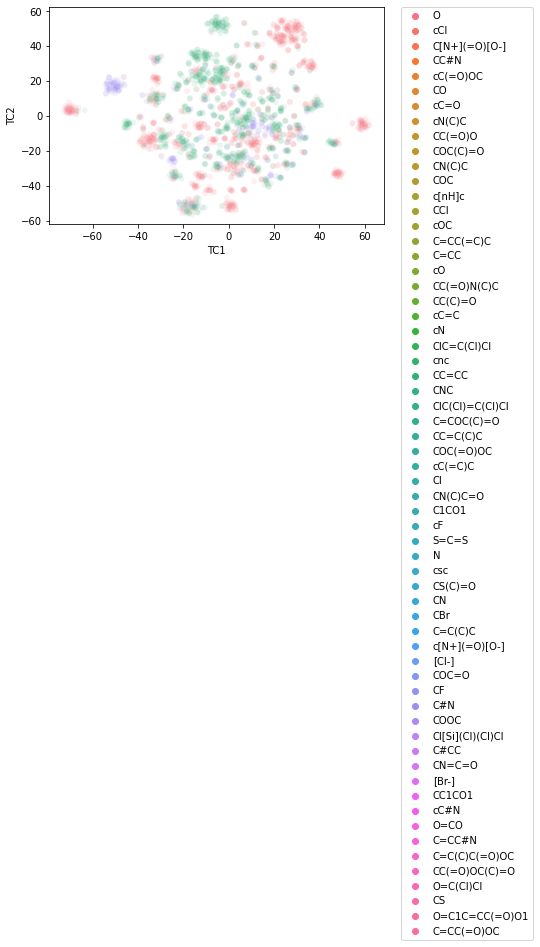

In [91]:
fig, ax = plt.subplots(1)
plot = sns.scatterplot(
    x="TC1",
    y="TC2",
    hue="fg",
    alpha=0.1,
    data=tnse_df_fg.sample(frac=1, random_state=10)
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig = plot.get_figure()
fig.tight_layout()
fig.savefig(DATA_PATH / "08_reporting" / "aspen" / "pretrained_fingerprints_t_sne_fgs.png", dpi=300)
# cb = plt.colorbar(sc)
# cb.solids.set(alpha=1)
# ax.set_xlabel("TC1")
# ax.set_ylabel("TC2")